# Train Transformer
This notebook trains the Transformer and embeds it in a translator class. It is based on the [Neural Machine Translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer) tutorial by TensorFlow.

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_text as text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [36]:
import config

## Dataset and tokenizers
Load dataset and tokenizers, see the tokenization notebook for details. Plot the distribution of tokens per sentence.

In [37]:
train_dataset = tf.data.Dataset.load(config.TRAIN_DATA_PATH)
val_dataset = tf.data.Dataset.load(config.VAL_DATA_PATH)
tokenizers = tf.saved_model.load(config.TOKENIZER_PATH)

In [38]:
lengths = []

for batch in train_dataset.take(50_000).batch(1024):
    eng_tokens = tokenizers.eng.tokenize(batch[:, 0])
    lengths.append(eng_tokens.row_lengths())
    nor_tokens = tokenizers.nor.tokenize(batch[:, 1])
    lengths.append(nor_tokens.row_lengths())

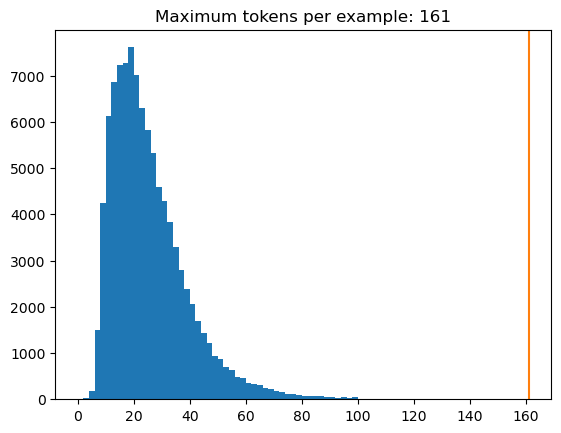

In [39]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 100, 51))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f"Maximum tokens per example: {max_length}");

## Batches
Split the tokenized dataset into batches for model training.

In [40]:
def prepare_batch(batch):
    eng = batch[:, 0]
    eng = tokenizers.eng.tokenize(eng)  # Output is ragged.
    eng = eng[:, : config.MAX_TOKENS]  # Trim to MAX_TOKENS.
    eng = eng.to_tensor()  # Convert to 0-padded dense Tensor

    nor = batch[:, 1]
    nor = tokenizers.nor.tokenize(nor)
    nor = nor[:, : (config.MAX_TOKENS + 1)]
    nor_inputs = nor[:, :-1].to_tensor()  # Drop the [END] tokens
    nor_labels = nor[:, 1:].to_tensor()  # Drop the [START] tokens

    return (eng, nor_inputs), nor_labels


def make_batches(ds):
    return (
        ds.batch(config.BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [41]:
val_batches = make_batches(val_dataset)
train_batches = make_batches(train_dataset)

## Transformer
Compile and train the Transformer model.

In [42]:
from model import Transformer, masked_loss, masked_accuracy, CustomSchedule

transformer = Transformer(
    num_layers=config.N_LAYERS,
    d_model=config.D_MODEL,
    num_heads=config.N_HEADS,
    dff=config.FFN_DIM,
    input_vocab_size=config.VOCAB_SIZE,
    target_vocab_size=config.VOCAB_SIZE,
    dropout_rate=config.DROPOUT_RATE,
)

In [43]:
# Build the transformer by applying it to a sample
for (eng, nor), nor_labels in train_batches.take(1):
    break
transformer((eng, nor))
transformer.summary()

Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  1308160   
                                                                 
 decoder_4 (Decoder)         multiple                  1839360   
                                                                 
 dense_84 (Dense)            multiple                  520000    
                                                                 
Total params: 3667520 (13.99 MB)
Trainable params: 3667520 (13.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
from model import CustomSchedule

learning_rate = CustomSchedule(config.D_MODEL)
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate, **config.OPTIMIZER_KWARGS
)

Text(0.5, 0, 'Train Step')

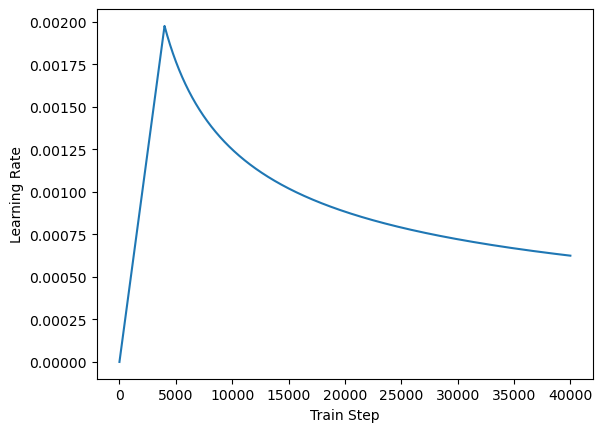

In [45]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [46]:
from model import masked_loss, masked_accuracy

transformer.compile(
    loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy]
)

In [47]:
transformer.fit(
    train_batches, epochs=config.N_EPOCHS, validation_data=val_batches
)

Epoch 1/3
16000/16000 [==============================] - 9250s 578ms/step - loss: 3.6293 - masked_accuracy: 0.4185 - val_loss: 2.3929 - val_masked_accuracy: 0.5781
Epoch 2/3
16000/16000 [==============================] - 9551s 597ms/step - loss: 2.4735 - masked_accuracy: 0.5655 - val_loss: 2.1664 - val_masked_accuracy: 0.6144
Epoch 3/3
16000/16000 [==============================] - 9306s 582ms/step - loss: 2.3201 - masked_accuracy: 0.5897 - val_loss: 2.0736 - val_masked_accuracy: 0.6306


## Translator
Use the Transformer model and tokenizers in a translator.

In [48]:
from model import Translator, ExportTranslator

translator = Translator(tokenizers, transformer, max_length=config.MAX_TOKENS)

In [49]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [51]:
sentence = "this is a problem we have to solve ."
ground_truth = "dette er et problem vi må løse ."

translated_text, _, _ = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : this is a problem we have to solve .
Prediction     : dette er et problem vi ma løse .
Ground truth   : dette er et problem vi må løse .


In [52]:
translator = ExportTranslator(translator)

In [59]:
translator(
    "My name is Julie and now I am going to eat pizza with my boyfriend"
).numpy().decode("utf-8")

[autoreload of config failed: Traceback (most recent call last):
  File "/Users/riegejon/miniforge3/envs/eng-nor-transformer/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riegejon/miniforge3/envs/eng-nor-transformer/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/riegejon/miniforge3/envs/eng-nor-transformer/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/riegejon/repos/eng-nor-transformer/config.py", line 14, in <module>
    BERT_TOKENIZER_PARAMS = {"lower_case": False, normalization_form: ""}
NameError: name 'normalization_form' is not def

'mitt navn er joloie og na er jeg a spise pizza med kjæreste'

In [54]:
tf.saved_model.save(translator, export_dir=config.TRANSLATOR_PATH)

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets
